In [3]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [4]:
def synthetic_data(w,b,num_examples): #@%save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0,1,(num_examples,len(w))) #torch.normal 函数用于生成符合正态分布（高斯分布）的随机数
    y = torch.matmul(X,w) + b  #计算输入数据X和权重向量w的矩阵乘法，然后加上偏置项b,其中torch.matmul(X, w)执行矩阵乘法
    y += torch.normal(0,0.01,y.shape)
    #向y添加噪声。它生成一个与y形状相同的张量，其元素是从均值为0、标准差为0.01的正态分布中随机抽取的，然后将这个噪声张量加到y上
    return X, y.reshape([-1,1])
    #返回输入数据X和添加了噪声的输出数据y。
    #y.reshape((-1, 1))确保y的形状是二维的，其中-1意味着该维度的大小是自动计算的，以保证总的元素数量不变，而1意味着第二维的大小是1

In [5]:
true_w = torch.tensor([2, -3.4]) #生成张量
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
#注意，[features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）]。

In [6]:
print('features:', features[0], '\nlabel', labels[0])

features: tensor([-0.7220,  0.5784]) 
label tensor([0.7901])


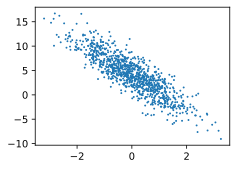

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

"\n's'：正方形\n'^'：三角形（向上）\n'd'：瘦菱形\n'*'：星形\n'h'：六边形1（水平）\n'H'：六边形2（水平且中心有一条线）\n'+'：加号\n'x'：叉号\n'D'：菱形\n'p'：五边形\n','：像素（很小的点）\n.'：点（非常小，可能看不见，取决于分辨率和点大小）\n'|'：垂直线\n'_'：水平线\n"

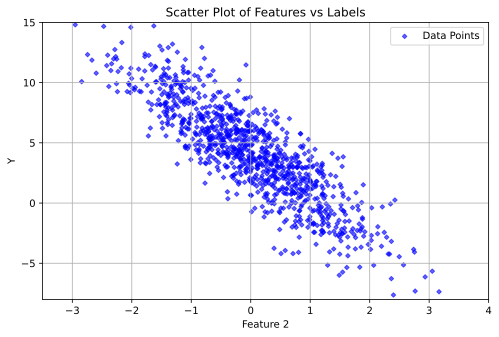

In [8]:
# 绘制散点图
plt.figure(figsize=(8, 5))  # 设置图形大小
plt.scatter(features[:, 1].numpy(), labels.numpy(), s=10, alpha=0.6, c='b',marker='D', label='Data Points')  # s是点的大小，alpha是透明度，c是颜色

plt.title('Scatter Plot of Features vs Labels')  # 设置标题
plt.xlabel('Feature 2')  # 设置x轴标签
plt.ylabel('Y')  # 设置y轴标签
plt.xlim(-3.5, 4)  # 设置x轴范围（根据数据调整）
plt.ylim(-8, 15)  # 设置y轴范围（根据数据调整）
plt.grid(True)  # 添加网格
plt.legend()  # 显示图例
"""
's'：正方形
'^'：三角形（向上）
'd'：瘦菱形
'*'：星形
'h'：六边形1（水平）
'H'：六边形2（水平且中心有一条线）
'+'：加号
'x'：叉号
'D'：菱形
'p'：五边形
','：像素（很小的点）
.'：点（非常小，可能看不见，取决于分辨率和点大小）
'|'：垂直线
'_'：水平线
"""

In [9]:
"""
使用random.shuffle函数对索引列表indices进行随机打乱。这是为了确保数据在迭代时是随机访问的，有助于模型的泛化能力
使用yield关键字返回当前批次的特征和标签
"""
def data_iter(bath_size, feathers, labels):
    #batch_size（每个批次的大小），features（特征数据），和labels（对应的标签数据）
    num_examples = len(features)
    indices = list(range(num_examples)) #创建了一个从0到num_examples-1的整数列表
    random.shuffle(indices)
    for i in range(0, num_examples, bath_size):
        bath_indices = torch.tensor(indices[i: min(i + bath_size, num_examples)])
    yield feathers[bath_indices], labels[bath_indices]

In [10]:
bath_size=10
for X,y in data_iter(bath_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.2507,  2.3339],
        [-0.5087, -0.6359],
        [-0.3369, -0.4456],
        [-1.1068,  3.2520],
        [-0.2215,  1.2680],
        [-1.2760,  0.4007],
        [-1.4462, -0.9170],
        [-1.4443,  0.3560],
        [ 0.3914, -0.5940],
        [-0.5828,  0.6800]]) 
 tensor([[-4.2382],
        [ 5.3594],
        [ 5.0444],
        [-9.0520],
        [-0.5551],
        [ 0.2888],
        [ 4.4179],
        [ 0.0949],
        [ 7.0161],
        [ 0.7249]])


In [11]:
#初始化模型参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
#参数requires_grad=True表示PyTorch需要计算这个张量关于图中其他变量的梯度
b = torch.zeros(1, requires_grad=True)
#b = torch.full((1,), 4.0, requires_grad=True)

In [12]:
#定义线性回归模型
def linreg(X, y, b): #@%save
    return torch.matmul(X, w) + b
#定义均方损失函数
def squared_loss(y_hat, y): #@save
    return (y_hat-y.reshape(y_hat.shape))**2 / 2
"""y 和 y_hat 的形状可能不匹配，函数通过 y.reshape(y_hat.shape) 将 y 的形状调整为与 y_hat 相同"""

'y 和 y_hat 的形状可能不匹配，函数通过 y.reshape(y_hat.shape) 将 y 的形状调整为与 y_hat 相同'

In [13]:
#定义优化算法
def sgd(params, lr, bath_size): #@%save
    with torch.no_grad(): #禁用梯度计算,减少内存消耗并加速计算
        for param in params:
            param -= lr * param.grad / bath_size
            param.grad.zero_()

In [15]:
# 初始化参数
lr = 0.03 
num_epochs = 3
net = linreg
loss = squared_loss
"""迭代周期个数num_epochs和学习率lr都是超参数"""

for epochs in range(num_epochs):
    for X, y in data_iter(bath_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, bath_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epochs + 1}, loss {float(train_l.mean()):f}')
        #print(w,b)

epoch 1, loss 0.000118
epoch 2, loss 0.000113
epoch 3, loss 0.000107


In [16]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0051, -0.0023], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0088], grad_fn=<RsubBackward1>)


In [17]:
"""如果我们将权重初始化为零，会发生什么。算法仍然有效吗？"""
w = torch.zeros((2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [20]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter(bath_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, bath_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000051
epoch 2, loss 0.000051
epoch 3, loss 0.000051


In [21]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0004,  0.0009], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0009], grad_fn=<RsubBackward1>)
